### Implementazione di un modello basato su un'architettura **encoder/decoder** in grado di segmentare l'immagine riconoscendo un animale domestico raffigurato all'interno.
    
La **Segmentazione di Immagini** è il processo, in computer-vision, di divisione di un'immagine in diverse zone (segmenti, gruppi di pixel) con lo scopo di modificare la rappresentazione di un'immagine in qualcosa di più significativo o facilmente analizzabile.    

-----

In questa esercitazione implementeremo un processo di image-segmentation sfruttando un modello di rete
neurale artificiale che sfrutta tecniche di deep-learning e un'architettura convolutiva.

    
L'architettura utilizzata unisce alla struttura encoder/decoder le **skip-connection** tipiche dell'architettura convolutiva **U-Net**, in modo da sfruttare il riconoscimento di caratteristiche sempre più dettagliate / rilevanti che avviene di layer in layer nella parte di encoder, per ricostruire al meglio la mappa di segmentazione in output alla parte di decoder.    
Per velocizzare il processo di addestramento, si è sfruttata la tecnica del **transfer-learning**, utilizzando un modello pre-addestrato come encoder, in particolare la rete **MobileNetV2**; i layer finali usati in questo modello per classificare non vengono considerati e l'output relativo alle feature estratte è posto in input alla parte di decoder, che ha una struttura analoga all'encoder ma ribaltata, struttura costruita così per facilitare la ricostruzione da singole feature estratte di una mappa di segmentazione.
    
Al fine di permettere una generalizzazione migliore del modello (nella parte finale di questo script verrà testato il modello su immagini diverse da quelle presenti nel dataset di addestramento e nel dataset usato per la validazione), sono state applicate delle tecniche di **data-augmentation** che permettono di modificare ogni singolo esempio di input con delle trasformazioni completamente casuali sulle relative immagini, fornendo al modello potenzialmente infiniti esempi su cui addestrarsi (o meglio, potenzialmente infinte variazioni del dataset di addestramento).    

In [1]:
pip install tensorflow-datasets

     ---------------------------------------- 0.0/101.3 kB ? eta -:--:--
     -------------------------------------- 101.3/101.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
   - -------------------------------------- 0.1/5.1 MB 4.2 MB/s eta 0:00:02
   -- ------------------------------------- 0.4/5.1 MB 4.4 MB/s eta 0:00:02
   ---- ----------------------------------- 0.6/5.1 MB 4.4 MB/s eta 0:00:02
   ----- ---------------------------------- 0.8/5.1 MB 4.3 MB/s eta 0:00:01
   ------- -------------------------------- 1.0/5.1 MB 4.4 MB/s eta 0:00:01
   --------- ------------------------------ 1.2/5.1 MB 4.1 MB/s eta 0:00:01
   ---------- ----------------------------- 1.3/5.1 MB 4.0 MB/s eta 

In [1]:
# importazione librerie necessarie

import matplotlib.pyplot as plt
import cv2  # pip install opencv-python
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

tfds: This is an abbreviation for TensorFlow Datasets, a library provided by TensorFlow for easily loading and managing datasets.

load: This is a function in the TFDS library used to load a dataset.

'oxford_iiit_pet:3.*.*': This is the name of the dataset being loaded. In this case, it's the Oxford-IIIT Pet dataset. The version number is specified as '3..', indicating that any version starting with '3' is acceptable. This is a way to ensure compatibility with different versions of the dataset.

with_info=True: This is an optional argument that, when set to True, not only loads the dataset but also returns additional information about the dataset. The additional information is stored in the variable info.

dataset: After running the tfds.load function, the loaded dataset is stored in the variable dataset. You can use this variable to access the actual data.

info: If with_info is set to True, information about the dataset, such as the number of examples, labels, and other metadata, is stored in the variable info. This can be useful for understanding the structure of the dataset before working with it.

In summary, this line of code loads the Oxford-IIIT Pet dataset (any version starting with '3') using TensorFlow Datasets. The dataset itself is stored in the variable dataset, and additional information about the dataset is stored in the variable info.

In [2]:
# recupero del dataset "Oxford-IIIT Pets Dataset"
# mette a disposizione delle tri-map, utili per
# l'addestramento di un modello in grado di
# segmentare le immagini di input.
#
# il dataset è formato da immagini di 37 razze
# di animali domestici, con 200 immagini per
# razza. Con ogni esempio è fornita la
# corrispondente etichetta e la maschera.
#
# Ad ogni pixel delle immagini viene assegnata
# una delle tre categorie:
#  1: animale
#  2: confine
#  3: sfondo

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\valen\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=

In [4]:
# recupero del dataset
# e applicazione di resize + normalizzazione

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255
    input_mask -= 1
    return input_image, input_mask

def load_example(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

ds_train = dataset['train'].map(load_example, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = dataset['test'].map(load_example, num_parallel_calls=tf.data.AUTOTUNE)

dataset['train'] and dataset['test'] are subsets of the original dataset, representing the training and testing splits, respectively.

The map function is used to apply the load_example function to each element of the dataset in parallel. num_parallel_calls=tf.data.AUTOTUNE allows TensorFlow to dynamically choose the number of parallel calls for better performance.

In [5]:
# definizione di una classe per applicare tecniche di
# data-augmentation sul dataset in modo automatico
# durante l'addestramento

class DataAugmentation(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # facendo usare lo stesso seed ad entrambe, verranno
    # applicate le stesse trasformazioni ad immagine e maschera
    self.augment_inputs_flip = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels_flip = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    self.augment_inputs_rotation = tf.keras.layers.RandomRotation(factor=(-0.05, 0.05), seed=seed)
    self.augment_labels_rotation = tf.keras.layers.RandomRotation(factor=(-0.05, 0.05), seed=seed)
    
  def call(self, inputs, labels):
    inputs = self.augment_inputs_flip(inputs)
    labels = self.augment_labels_flip(labels)

    inputs = self.augment_inputs_rotation(inputs)
    labels = self.augment_labels_rotation(labels)
    
    return inputs, labels

In [6]:
# costruzione della pipeline di input
# per l'addestramento

BATCH_SIZE = 4
BUFFER_SIZE = 1024

ds_train_batched =(
    ds_train
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .cache()
    .repeat()
    .map(DataAugmentation())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

ds_test_batched = ds_test.batch(BATCH_SIZE)

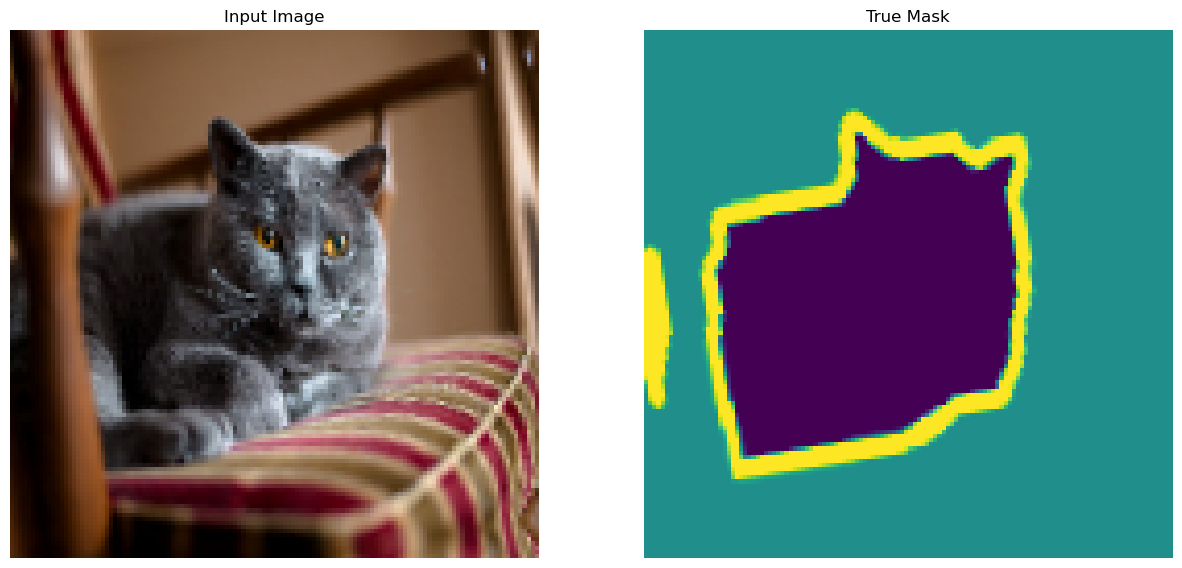

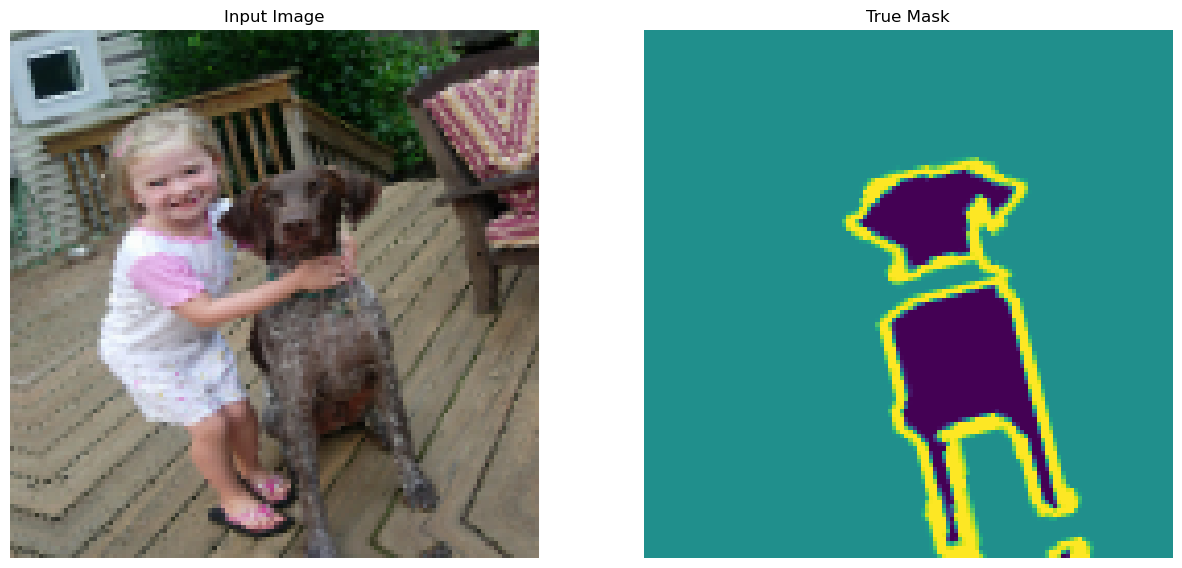

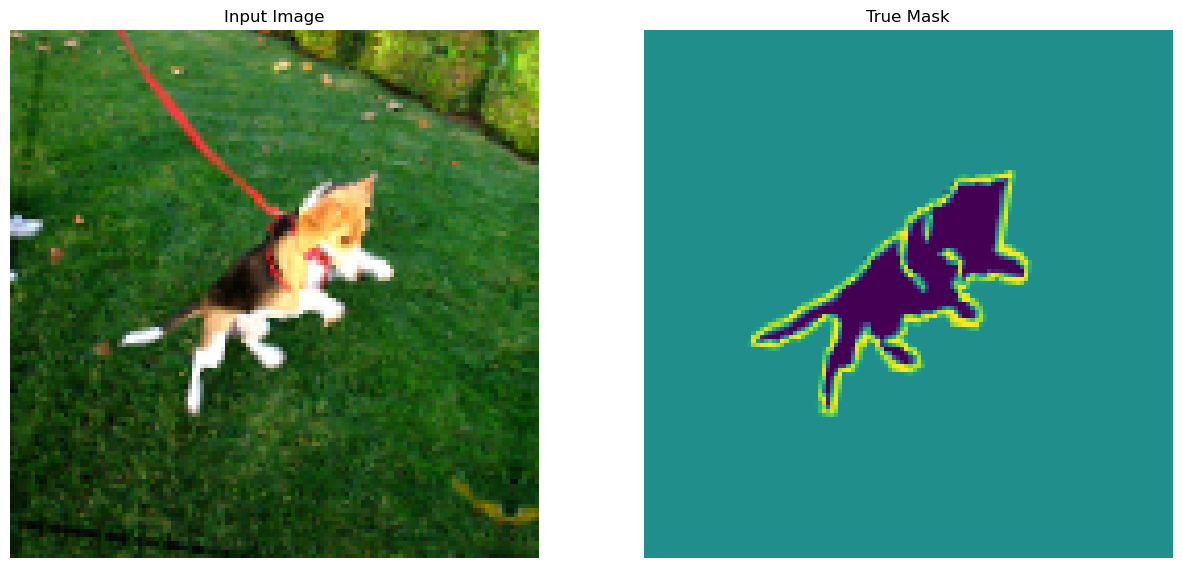

In [7]:
# visualizzazione di tre esempi

def visualizza(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for images, masks in ds_train_batched.take(3):  # recupero tre batch
    sample_image, sample_mask = images[0], masks[0]  # recupero il primo esempio del batch attuale
    visualizza([sample_image, sample_mask])

In [8]:
# recupero del modello standard MobileNetV2 pre-addestrato
# usato poi come encoder nel modello finale
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [9]:
# recupero dell'output di alcuni layer del modello MobileNetV2

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  #  8x8
    'block_16_project',      #  4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [10]:
print(base_model_outputs)

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>, <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>, <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>, <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>, <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]


In [11]:
# creazione del blocco encoder

encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
encoder.trainable = False

In [12]:
# creazione del blocco di decoder
# implementato come una serie di layer
# di up-sampling
# ogni "upsample" è un modello sequenziale
# composto da un layer di de-convoluzione
# (Conv2DTranspose) con dropout al 50%
# con funzione di attivazione swish

def upsample(filters, kernel):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, kernel, strides=2, padding='same', use_bias=False))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Activation('swish'))
    return model

decoder = [
    upsample(512, 3),  #  4x4  ->  8x8
    upsample(256, 3),  #  8x8  -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [13]:
# definizione del modello U-Net utilizzato

def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # down-sampling iniziale (encoder)
    skips = encoder(inputs)
    for s in skips:
        print(f"Plain -> {s.get_shape()}")
    x = skips[-1]
    skips = list( reversed(skips[:-1]) ) 
    for s in skips:
        print(f"Reversed -> {s.get_shape()}")

    # up-sampling (decoder) e associazione delle
    # skip-connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        # print("Concatenation between {x.name} and {skip.name}")
        x = concat([x, skip])

    # layer finale del modello che restituisce
    # un'immagine di dimensioni uguali all'immagine
    # di input, i cui pixel hanno valore 0, 1 o 2
    # in base alla classe di appartenenza (animale,
    # confine, non animale)
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  # 64x64 -> 128x128
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
# creazione e compilazione del modello

OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # problema multiclasse -> animale, confine,
                                                                           #                         non animale
    metrics=['accuracy']
)

Plain -> (None, 64, 64, 96)
Plain -> (None, 32, 32, 144)
Plain -> (None, 16, 16, 192)
Plain -> (None, 8, 8, 576)
Plain -> (None, 4, 4, 320)
Reversed -> (None, 8, 8, 576)
Reversed -> (None, 16, 16, 192)
Reversed -> (None, 32, 32, 144)
Reversed -> (None, 64, 64, 96)


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 64, 64, 96),         1841984   ['input_2[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

In [16]:
def crea_maschera(pred_mask):
    # la label assegnata ad un pixel è quella corrispondente
    # al canale colore con il valore più grande
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


# definizione di un metodo per visualizzare le predizioni del modello

def visualizza_predizioni(num=1):
    visualizza([sample_image, sample_mask, crea_maschera(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 4s 4s/step


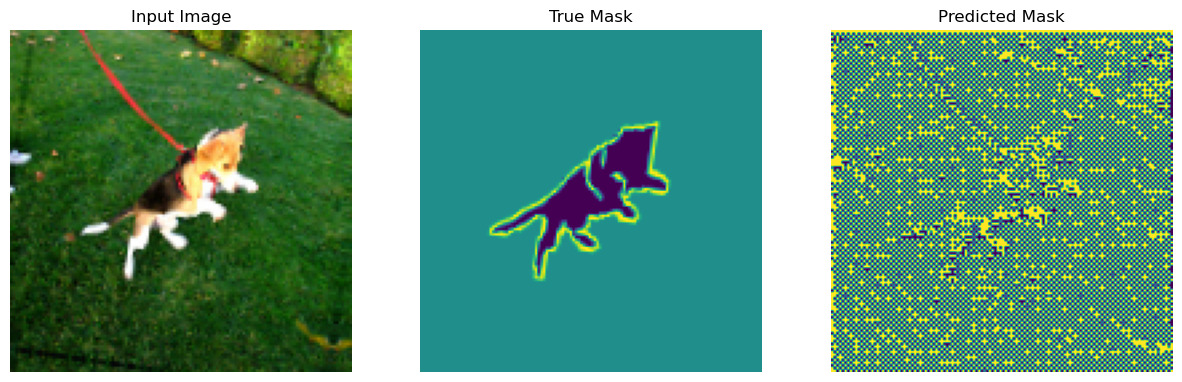

In [17]:
# visualizzazione delle predizioni
# chiamando il modello non ancora addestrato


visualizza_predizioni()

In [18]:
# creazione di un callback per visualizzare come migliora
# il modello durante l'addestramento ogni 10 epoche

class TestCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0 and epoch > 0:
            print ('\n\nPredizione epoca {}\n'.format(epoch + 1))
            visualizza_predizioni()
            print('\n', '-' * 100, '\n')

In [19]:
# configurazione ultimi iper-parametri

STEP_PER_EPOCA = info.splits['train'].num_examples // BATCH_SIZE
EPOCHE = 5
STEP_DI_VALIDAZIONE = info.splits['test'].num_examples // BATCH_SIZE

# addestramento del modello

model_history = model.fit(
    ds_train_batched,
    epochs=EPOCHE,
    steps_per_epoch=STEP_PER_EPOCA,
    validation_steps=STEP_DI_VALIDAZIONE,
    validation_data=ds_test_batched,
    callbacks=[TestCallback()]
)

Epoch 1/5



920/920 [==============================] - 375s 392ms/step - loss: 0.4109 - accuracy: 0.7982 - val_loss: 0.3591 - val_accuracy: 0.8514
Epoch 2/5
920/920 [==============================] - 385s 418ms/step - loss: 0.3206 - accuracy: 0.8346 - val_loss: 0.3447 - val_accuracy: 0.8614
Epoch 3/5
920/920 [==============================] - 323s 351ms/step - loss: 0.3072 - accuracy: 0.8395 - val_loss: 0.3547 - val_accuracy: 0.8640
Epoch 4/5
920/920 [==============================] - 303s 329ms/step - loss: 0.2978 - accuracy: 0.8431 - val_loss: 0.3483 - val_accuracy: 0.8668
Epoch 5/5
920/920 [==============================] - 279s 303ms/step - loss: 0.2917 - accuracy: 0.8452 - val_loss: 0.3535 - val_accuracy: 0.8679


1/1 [==============================] - 0s 197ms/step


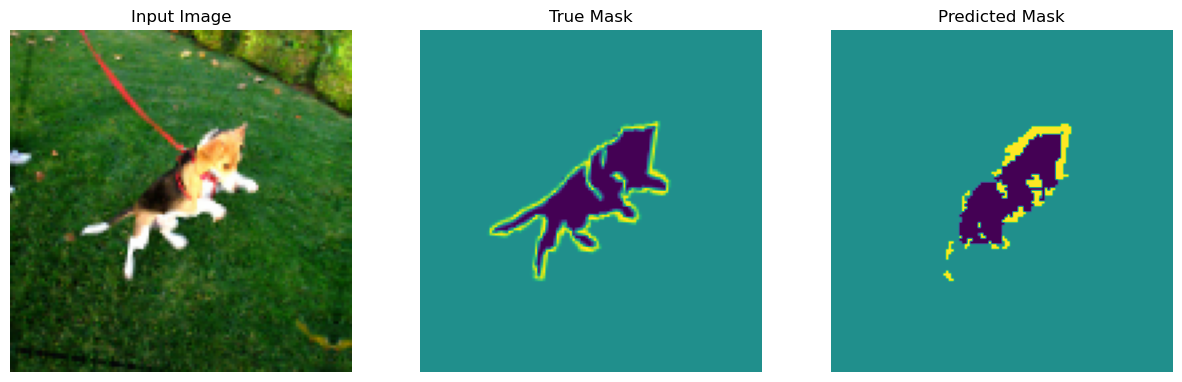

In [20]:
# visualizzazione predizione dopo l'addestramento

visualizza_predizioni()

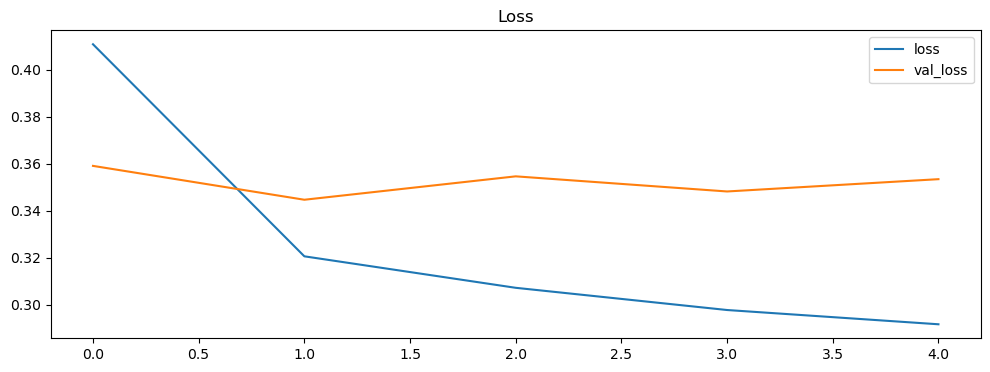

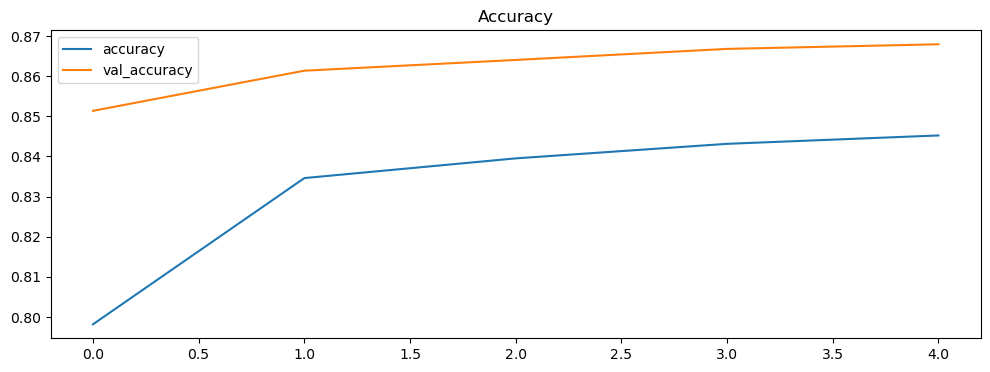

In [21]:
# visualizzazione andamento addestramento

plt.figure(figsize=(12, 4))
plt.title('Loss')
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.title('Accuracy')
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 212ms/step


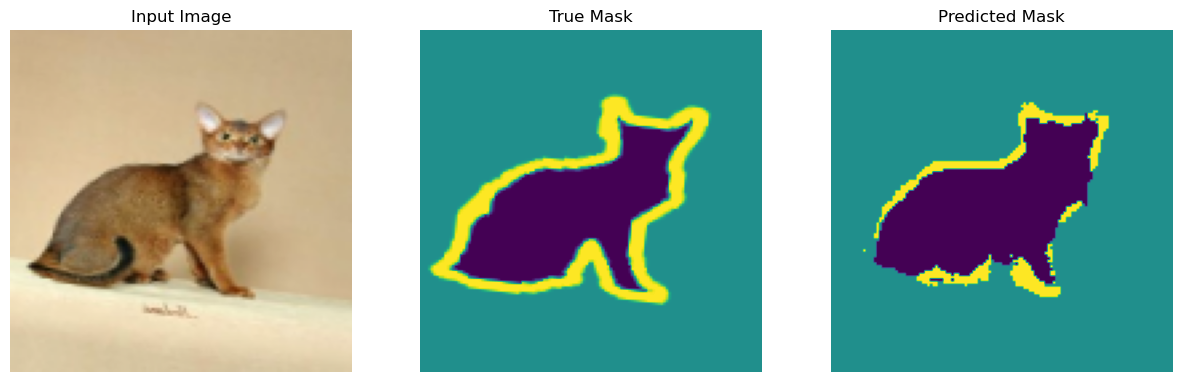

1/1 [==============================] - 0s 135ms/step


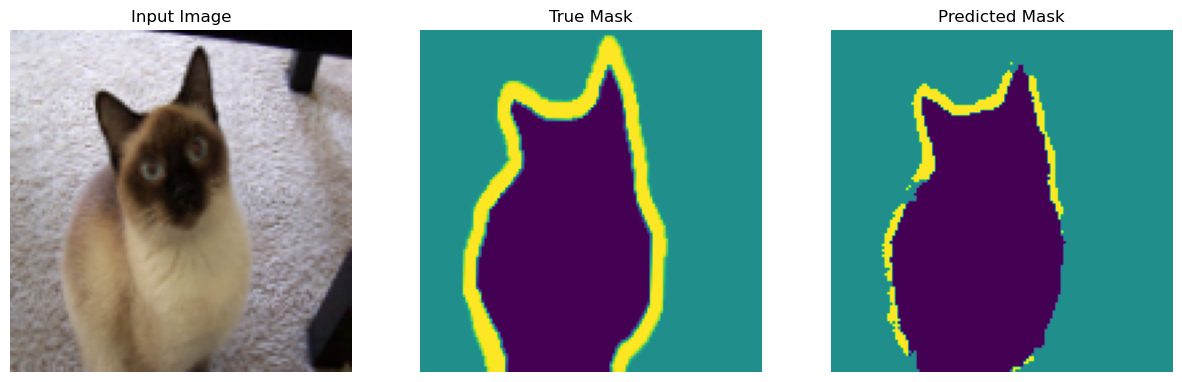

1/1 [==============================] - 0s 142ms/step


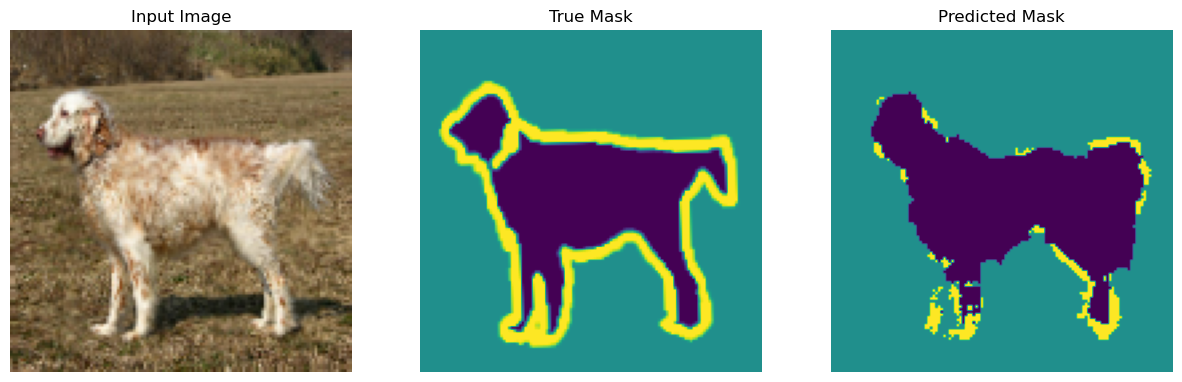

1/1 [==============================] - 0s 124ms/step


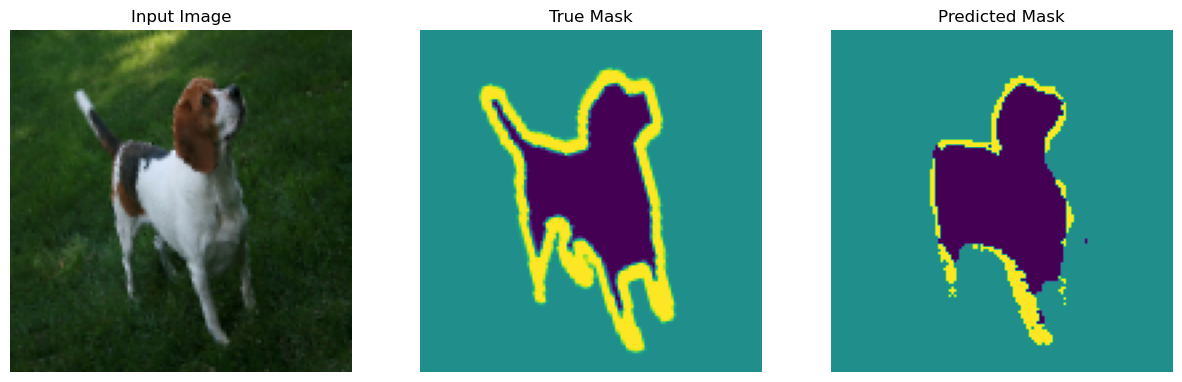

1/1 [==============================] - 0s 76ms/step


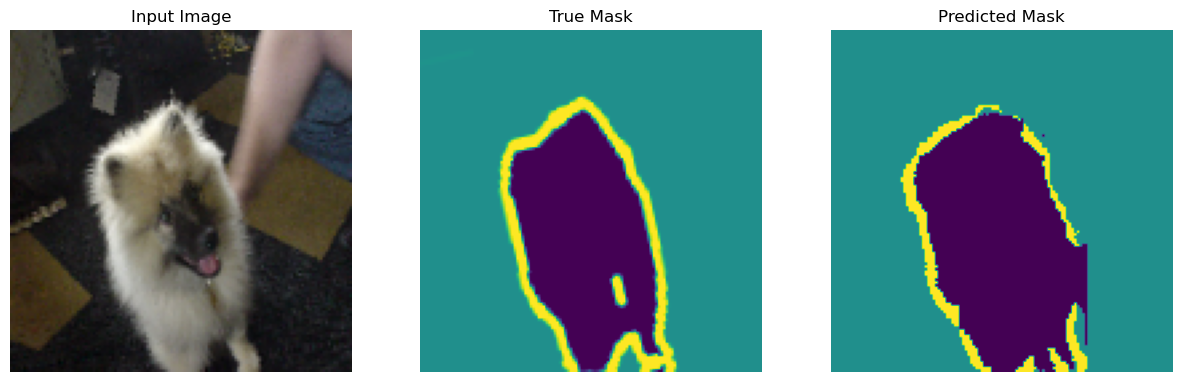

1/1 [==============================] - 0s 89ms/step


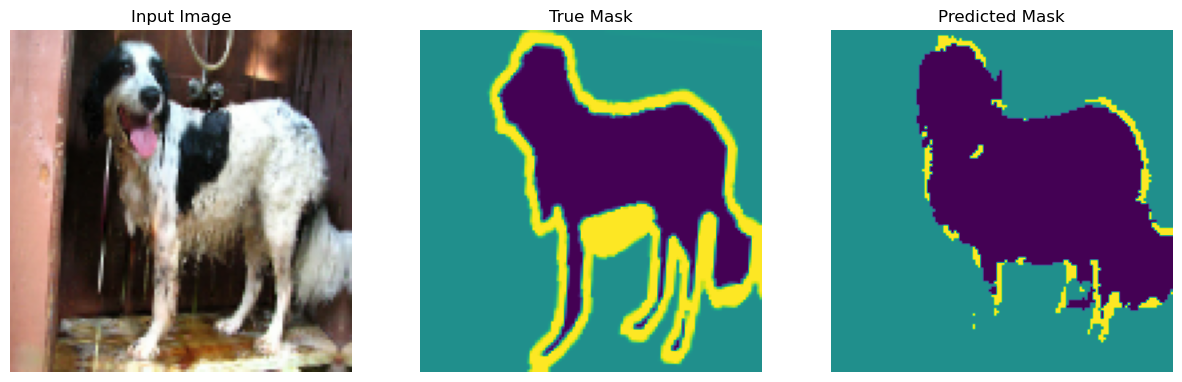

1/1 [==============================] - 0s 101ms/step


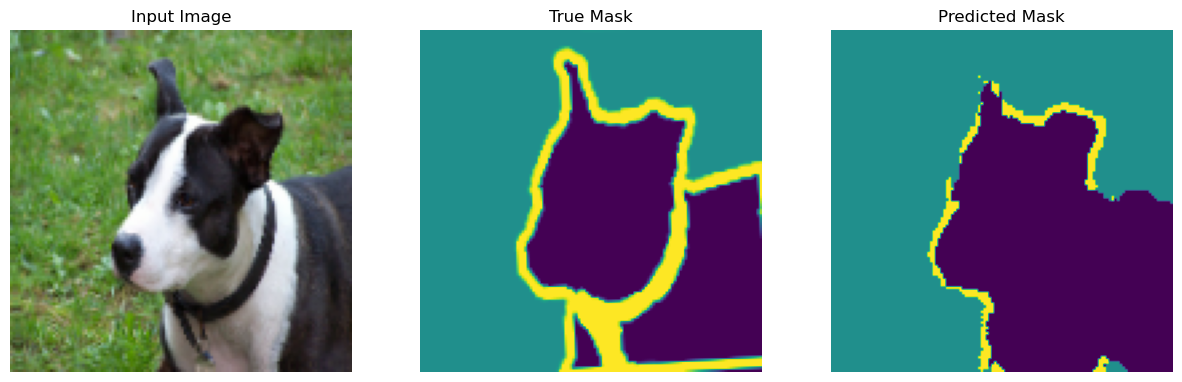

1/1 [==============================] - 0s 82ms/step


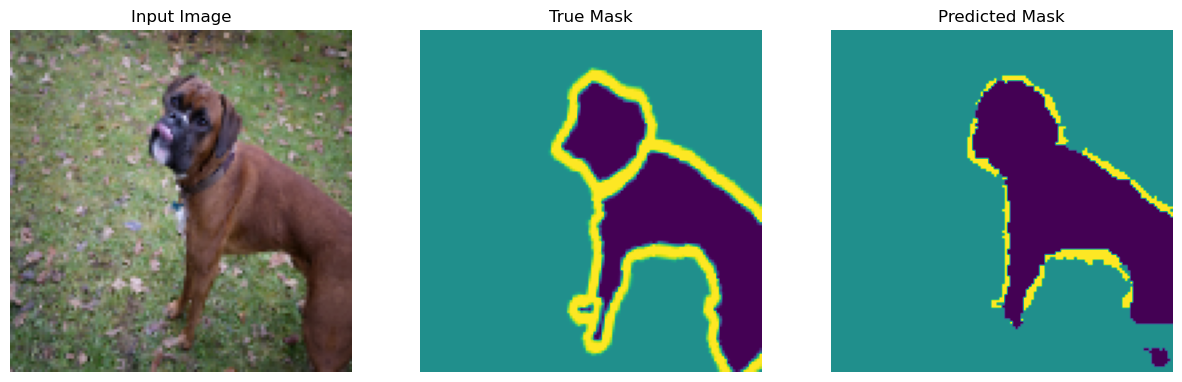

1/1 [==============================] - 0s 99ms/step


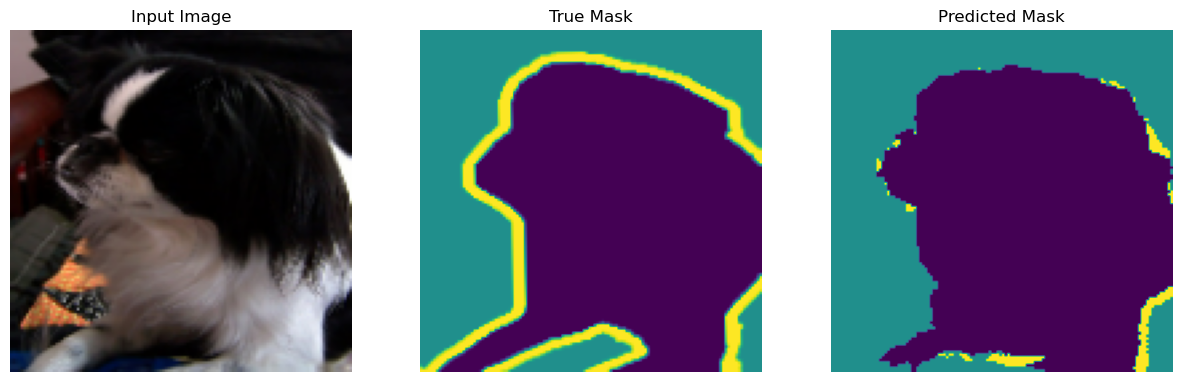

1/1 [==============================] - 0s 98ms/step


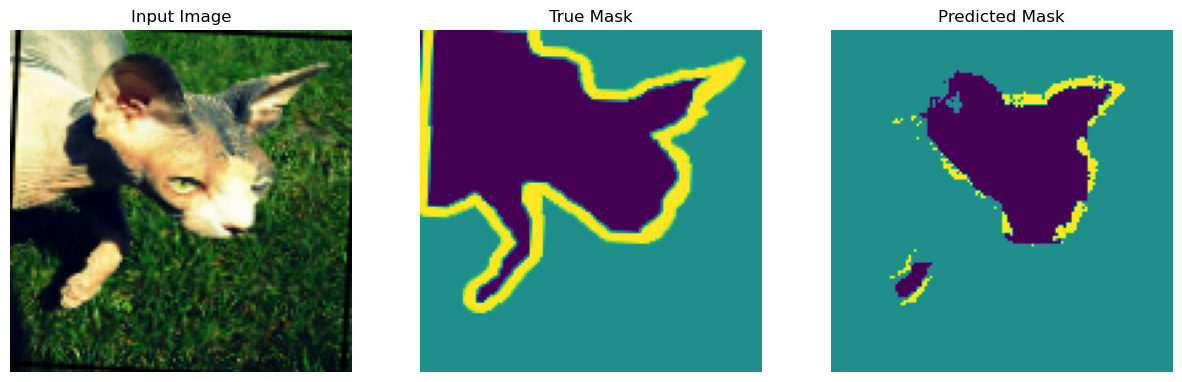

In [22]:
# previsioni su nuovi esempi dal dataset di test

for images, masks in ds_train_batched.take(10):
    sample_image, sample_mask = images[0], masks[0]
    visualizza_predizioni()

In [23]:
# test su nuove immagini
# recuperate da internet 
# (non dal dataset originale)

def predizione_nuove_immagini(filename):
    img = cv2.imread(filename)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, (128, 128))

    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(121)
    img = img[...,::-1]  # inversione dei canali colore per compatibilità con matplotlib
    ax1.imshow(img)
    img = img[...,::-1]
    ax1.axis('off')
    
    maschera_predetta = model.predict(np.asarray([img]))[0]
    risultato = crea_maschera([maschera_predetta])

    ax2 = fig.add_subplot(122)
    ax2.imshow(risultato)
    ax2.axis('off')
    
    plt.show()

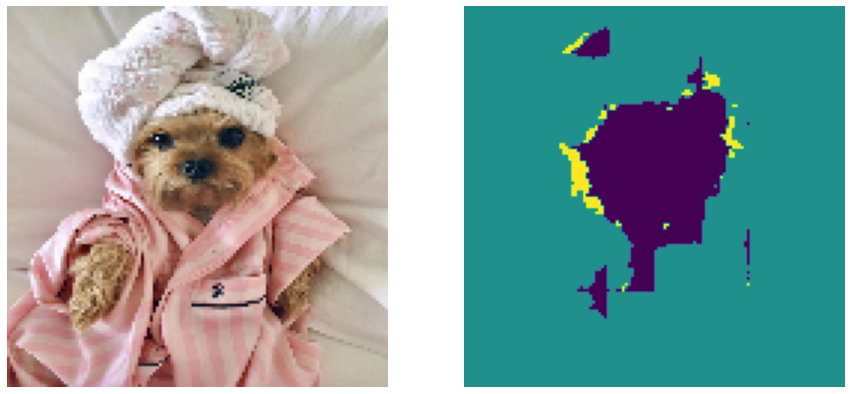

In [25]:
predizione_nuove_immagini('cane-buffo.jpg')

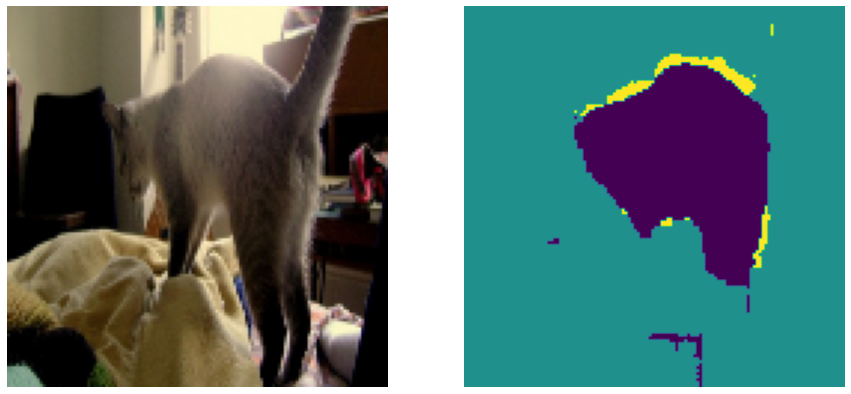

In [26]:
predizione_nuove_immagini('gatto-casa.png')

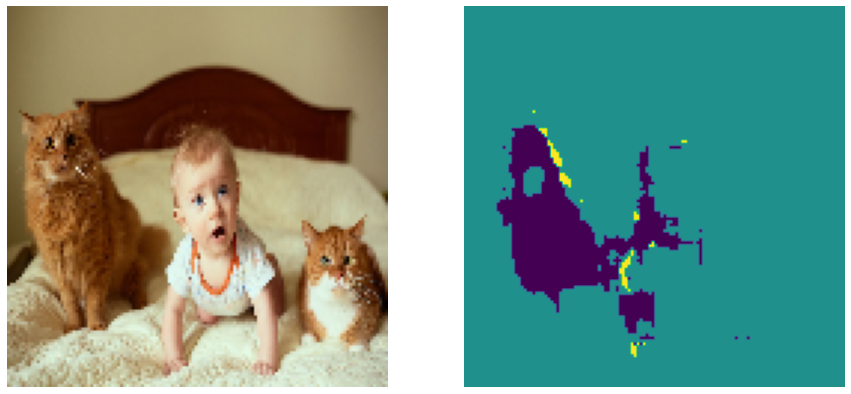

In [27]:
# test con immagini più complesse e diverse dal dataset
# di addestramento: più soggetti in un'immagine

predizione_nuove_immagini('gatti-bambino.jpg')

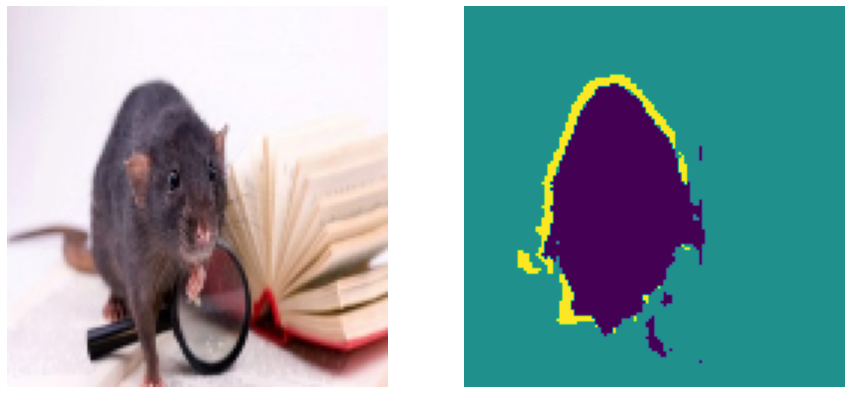

In [28]:
# test con un soggetto non presente nel dataset
# di addestramento: un topo

predizione_nuove_immagini('topo.jpg')

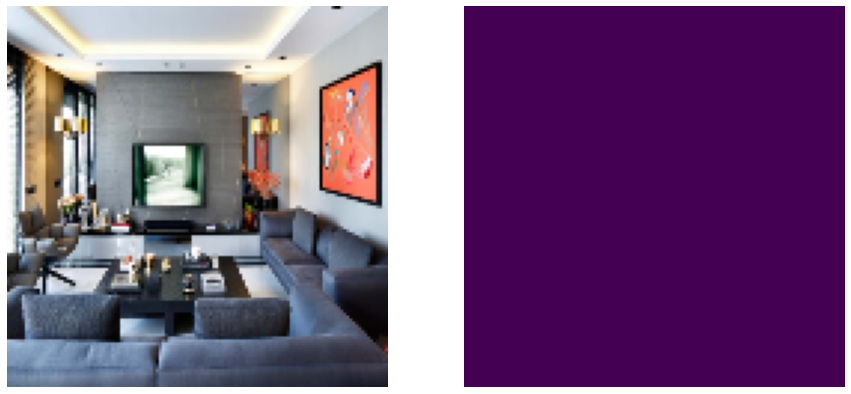

In [29]:
# test su un'immagine senza alcun animale
# domestico raffigurato

predizione_nuove_immagini('casa.jpg')